# Problema de Particionamiento de un grafo en Componentes Conexas

<H1 align="center"> Formulación de Flujo 2 + Cortes </H1>

## Problema

Dado un grafo general $G=(V, E)$ de $n$ nodos con peso determinado en sus arcos $d_{ij}$ para todo $\{i,j\}\in E$, particionar el grafo en $k$ componentes conexas, donde $V=V_1, V_2,..., V_j$ con $V_i \cap V_j=\emptyset \quad\forall j \in [k]$, con el objetivo de minimizar la distancia total. Todas estas componentes conexas deben tener incorporados a lo menos 2 nodos.


### Parámetros

<div class="alert alert-block alert-info">

0. $V:$ es un conjunto con los nodos en el grafo,
1. $n:$ es la cantidad de nodos en el grafo,
2. $k:$ es la cantidad de componentes conexas en que se quiere dividir el grafo,
3. $γ:$ es el mínimo número de nodos en cada componente,
4. $A:$ es una lista que guarda las aristas del grafo de la forma $\{i,j\}$ con $i < j$,  
5. $AA:$ es una lista con las aristas artificiales que salen de los nodos artificiales hacia todos los nodos del grafo,
6. $E:$ es una lista con las aristas del grafo aumentante, es decir $E = A \cup AA$
7. $B:$ es una lista que guarda las aristas del grafo de la forma $\{j,i\}$ con $i < j$,  
8. $d_{ij}:$ es el peso de la arista $\{i,j\}$, $\forall \{i,j\} \in A$,  
</div>

### Variables

$y_i^{c}=\left \{ \begin{matrix} 1, &\mbox{si }i\in V_c
\\ 0, &\mbox{otro }\end{matrix}\right.$

$x_{ij}=\left \{ \begin{matrix} 1, &\mbox{si los nodos } i, j \in V_c \mbox{ y además la arista } \{i,j\}\in A
\\ 0, &\mbox{otro }\end{matrix}\right.$

$x_{ci}=\left \{ \begin{matrix} 1, &\mbox{ se activa la arista artificial } \{c,i\}\in AA
\\ 0, &\mbox{otro }\end{matrix}\right.$

$f_{ij} \in \mathbb {R}^{+}$ es la cantidad de flujo en el arco $\{i,j\}\in E \cup B$,

### Modelo

\begin{align}
\min &\sum_{\{i,j\} \in A} d_{ij}\, x_{ij}\\
\text{s.a.} & \\
&\sum_{c\in [k]} y_i^{c} = 1, \qquad\qquad \forall i \in V,\\
&y_i^{c}+y_j^{c}-x_{ij} \,\,\leq 1, \quad \,\forall \{i,j\}\in A, \quad \forall c \in [k],\\
&y_i^{c}+y_j^{l}+x_{ij} \leq 2, \quad \forall \{i,j\}\in A, \quad \forall c,l \in [k], c \neq l\\
&\sum_{i\in V} x_{ci} = 1, \qquad\qquad \forall \{c,i\}\in AA ,\\
&\sum_{i\in V} f_{ci} = \sum_{i\in V} y_i^{c}, \qquad\qquad \forall \{c,i\}\in AA, \quad \forall c \in [k], \\
&\sum_{(i,j)\in E} f_{ij} - \sum_{(j,i)\in A} f_{ji} = 1, \qquad\qquad \forall j \in V, \\
&f_{ij} + f_{ji} \leq (n-(k-1)γ)x_{ij}, \quad \forall \{i,j\}\in A,\\
&γx_{ci}\leq f_{ci} \leq (n-(k-1)γ)x_{ci}, \quad \forall \{c,i\}\in AA,\\
&y_i^{c}\in \{0, 1\}, \qquad \forall i\in V, \quad \forall c \in [k],\\
&x_{ij}\in \{0, 1\}, \qquad \forall \{i,j\}\in E,\\
&f_{ij} \in \mathbb {R}^{+}, \qquad\quad \forall \{i,j\}\in E\cup B.\\
\end{align}

## Grafo

In [1]:
# PAQUETES
# Gurobi Python Interface
# https://www.gurobi.com/documentation/8.1/quickstart_windows/py_python_interface
from   gurobipy   import *
import pandas as pd    # https://pandas.pydata.org/
import numpy  as np    # Numpy
import random as r
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from igraph import *

In [2]:
# Aliases
seeds = np.random.seed

## Ingresando Manualmente el grafo

In [3]:
#INSTANCIA (70, 9) TERCERA ITERACION
n = 70;
m = 800;
seed = 63
# Generar un grafo de forma aleatoria con n nodos y m aristas
G = nx.dense_gnm_random_graph(n, m, seed)
V = G.nodes                                 # Conjunto de nodos
A = G.edges                                 # Conjunto de aristas
seeds(63)                                  # Fijamos la semilla de números aleatorios
W = np.random.randint(1,10, len(A))   # Creamos un vector de pesos aleatorios

for i, e in enumerate(A()):
    G[e[0]][e[1]]['w'] = W[i]               # Para corroborar: G[e[0]][e[1]]['w']
print(nx.info(G))
#print(nx.get_edge_attributes(G, 'w'))
costo = sum([ G[a[0]][a[1]]['w'] for a in G.edges])
print("El costo del grafo es:", costo)

Name: 
Type: Graph
Number of nodes: 70
Number of edges: 800
Average degree:  22.8571
El costo del grafo es: 3961


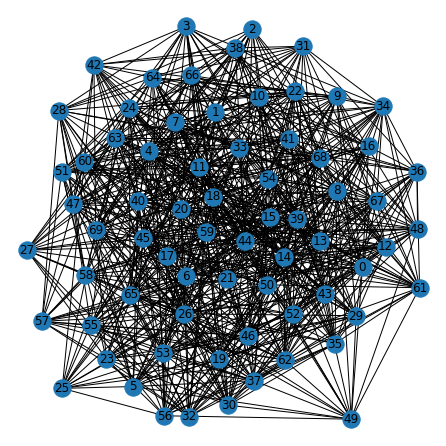

In [4]:
plt.figure(figsize=(6,6))
nx.draw(G, nx.spring_layout(G), with_labels=True)
plt.draw()

In [5]:
print(nx.is_connected(G))

True


In [6]:
#print(nx.get_edge_attributes(G, 'w'))

In [7]:
d = nx.get_edge_attributes(G, 'w')
B = [(j,i) for (i,j) in d.keys()]
NA = list(nx.non_edges(G))
A=list(G.edges())

### Información del grafo

In [8]:
# Compilar esta linea después de la linea anterior cuando ingresamos manualmente el grafo
V = G.nodes
n = len(V)
M = 2*n;


### Información de la instancia

In [9]:
c = 9;     C = tuplelist(range(c));
γ = 2      # numero de nodos minimo

### Creamos el grafo aumentado

In [10]:
V

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69))

In [11]:
# Creamos los k nodos artificiales
VV = tuplelist(range(n,n+c))
# Crearemos los arcos artificiales que van desde los nodos artificiales hacia cada nodo del grafo original
AA=[]
for i in VV:
    for j in V:
        # el arco va desde el nodo artificial hacia los nodos originales del grafo
        AA.append((i,j))

In [12]:
# E contiene los arcos del grafo aumentante, es decir arcos del grafo original + arcos artificiales
E = A+AA

### Arcos entrantes y salientes del grafo
#### Compilar la siguiente linea ya sea si el grafo ingresa de forma aleatoria o manualmente, en los arcos entrantes se consideran también los arcos artificiales

In [13]:
# crear diccionarios de arcos salientes / entrantes
salientes = {i : [(j,k) for (k,j) in A if j==i]+[(k,j) for (k,j) in A if k==i] for i in V}
entrantes = {i : [(j,k) for (j,k) in A+AA if k==i]+[(j,k) for (k,j) in A+AA if k==i] for i in V}


<div class="alert alert-block alert-info">
<b>Modelo</b>

1. $x:$ es un diccionario para almacenar la variable binaria $x_{ij}$,
2. $y:$ es un diccionario para almacenar la variable binaria $y_j^c$,
3. $f:$ es un diccionario para almacenar la variable real positiva de flujo $f_{ij}$,
</div>

In [14]:
del mo

NameError: name 'mo' is not defined

In [ ]:
if 'mo' in globals():        mo.dispose();    disposeDefaultEnv();    del mo

In [15]:
# Modelo:
mo = Model()
x = {} # diccionario para la variable x
y = {} # diccionario para la variable y
f = {} # diccionario para la variable f

mo.update()

Academic license - for non-commercial use only - expires 2022-04-07
Using license file C:\Users\academico\gurobi.lic


In [16]:
# esta variable es para el modelo relajado
#m = {} # diccionario para la variable x

### Creación de Variables

In [17]:
# Variables
start = time.time()
# x_i_j_k
x = mo.addVars(E, vtype = GRB.BINARY, name="x", lb = 0)

# y_i_k
y = mo.addVars(V, C, vtype = GRB.BINARY, name="y", lb = 0)
       
# f_i_j_k
f = mo.addVars(E+B, vtype = GRB.CONTINUOUS, name="f", lb = 0)
    
end = time.time()
print ('El tiempo que toma crear las variables es:', end-start)
mo.update()

El tiempo que toma crear las variables es: 0.015637874603271484


### Función objetivo

In [18]:
# Función objetivo
start = time.time()
obj=quicksum(x[i,j]*d[i,j] for (i,j) in A)
mo.setObjective(obj, GRB.MINIMIZE)
end = time.time()
print ('El tiempo que toma crear la función objetivo es:', end-start)
mo.update()

El tiempo que toma crear la función objetivo es: 0.0


### Restricciones

<div class="alert alert-block alert-info">
<b>Restricción de pertenencia</b>
\begin{equation}
    \sum_{c\in [k]} y_i^{c} = 1, \qquad\qquad \forall i \in V,\\
\end{equation}  
Esta restricción garantiza que cada nodo pertenezca exactamente a una sola componente conexa.
</div>

In [19]:
# Restricción de pertenencia
start = time.time() 
for i in V:
    r1_name = "Res_pertenencia1_" + str(i)
    mo.addConstr(quicksum(y[i,k] for k in C) == 1, name = r1_name)
end = time.time()
print ('El tiempo que toma crear estas restricciones son:', end-start)

El tiempo que toma crear estas restricciones son: 0.0


<div class="alert alert-block alert-info">
<b>Restricción de pertenencia de aristas</b> 
\begin{equation}
   y_i^{c}+y_j^{c}-x_{ij} \,\,\leq 1, \quad \,\forall \{i,j\}\in A, \quad \forall c \in [k],\\
\end{equation}
Esta restricción garantiza que si los nodos $i, j \in V_c \mbox{ y además la arista } \{i,j\}\in E$ entonces la 
arista $(i,j)$ también estará en la misma componente conexa que los nodos $i$ y $j$.

</div>

In [20]:
start = time.time()
cont1=0
for k in C:
    for (i,j) in A:
        cont1+=1
        r2_name = "Res_arista_per_" + str(cont1)
        mo.addConstr(y[i,k]+y[j,k]-x[i,j] <= 1, name = r2_name)

end = time.time()
print ('El tiempo que toma crear estas restricciones son:', end-start)

El tiempo que toma crear estas restricciones son: 0.0624847412109375


<div class="alert alert-block alert-info">
<b>Restricción 3</b> 
\begin{equation}
    y_i^{c}+y_j^{l}+x_{ij} \leq 2, \quad \forall \{i,j\}\in A, \quad \forall c,l \in [k], c \neq l\\
\end{equation}
Esta restricción garantiza que si dos nodos $i, j$ no están en la misma componente, entonces de existir una arista $(i,j)$, la variable $x_{i,j}$ toma el valor de $0$

</div>

In [21]:
# Restricción que fija la arista xij en 0 si dos nodos i,j perteneces a diferentes componentes
start = time.time()
cont2=0
for k in C:
    for l in C:
        for (i,j) in A:
            if k != l:
                cont2+=1
                r3_name = "Res_arista_per2_" + str(cont2)
                mo.addConstr(y[i,k]+y[j,l]+x[i,j] <= 2, name = r3_name)

end = time.time()
print ('El tiempo que toma crear estas restricciones es:', end-start)
mo.update()

El tiempo que toma crear estas restricciones es: 0.5570642948150635


<div class="alert alert-block alert-info">
<b>Restricción 4</b> 
\begin{equation}
    \sum_{i\in V} x_{ci} = 1, \qquad\qquad \forall \{c,i\}\in AA ,\\
\end{equation}   
Esta restricción garantiza que unicamente una de las aristas que salen de un nodo artificial $x_{ci}$ tome el valor de 1, y solo por ahí saldrán n' unidades de flujo, donde n' es la cantidad de nodos en la componenente conexa que representa dicho nodo artificial.

</div>

In [22]:
start = time.time() 
cont = 0
for k in VV:
    r4_name = "Res_activar_arco_comp_" + str(cont)
    cont += 1
    mo.addConstr(quicksum(x[k,i] for i in V) == 1, name = r4_name)
end = time.time()
print ('El tiempo que toma crear estas restricciones son:', end-start)

El tiempo que toma crear estas restricciones son: 0.0


<div class="alert alert-block alert-info">
<b>Restricción 5</b> 
\begin{equation}
    \sum_{i\in V} f_{ci} = \sum_{i\in V} y_i^{c}, \qquad\qquad \forall \{c,i\}\in AA, \quad \forall c \in [k], \\
\end{equation}   
Esta restricción garantiza que el flujo que se enviará a través del arco activo $x_{ci}$ equivale a la cantidad de nodos en dicha componente conexa $c$

</div>

In [23]:
start = time.time()
cont3=0
for k in C:
    cont3+=1
    r5_name = "Res_flujo_arcoAct_comp" + str(k)
    mo.addConstr(quicksum(f[k+n,i] for i in V) == quicksum(y[i,k] for i in V), name = r5_name)

end = time.time()
print ('El tiempo que toma crear estas restricciones es:', end-start)
mo.update()

El tiempo que toma crear estas restricciones es: 0.0


<div class="alert alert-block alert-info">
<b>Restricción 6</b> 
\begin{equation}
    \sum_{(i,j)\in E} f_{ij} - \sum_{(j,i)\in A} f_{ji} = 1, \qquad\qquad \forall j \in V, \\
\end{equation}  
Suma de flujos en el nodo $j$

</div>

In [24]:
start = time.time()
cont4=0
for j in V:
    cont4+=1
    r6_name = "Res_flujo_nodo" + str(j)
    mo.addConstr(quicksum(f[i,l] for (i,l) in entrantes[j]) - quicksum(f[l,i] for (l,i) in salientes[j])== 1, name = r6_name)

end = time.time()
print ('El tiempo que toma crear estas restricciones es:', end-start)
mo.update()

El tiempo que toma crear estas restricciones es: 0.0


<div class="alert alert-block alert-info">
<b>Restricción 7</b> 
\begin{equation}
    f_{ij} + f_{ji} \leq (n-(k-1)γ)x_{ij}, \quad \forall \{i,j\}\in A,\\
\end{equation}  
Flujo máximo en los arcos de grafo original

</div>

In [25]:
start = time.time()
cont5=0
for (i,j) in A:
    cont5+=1
    r7_name = "Res_flujo2_" + str(cont5)
    mo.addConstr(f[i,j]+f[j,i] <= (n-(c-1)*γ)*x[i,j], name = r7_name)

end = time.time()
print ('El tiempo que toma crear estas restricciones son:', end-start)

El tiempo que toma crear estas restricciones son: 0.015232086181640625


<div class="alert alert-block alert-info">
<b>Restricción 8</b> 
\begin{equation}
    γx_{ci}\leq f_{ci} \leq (n-(k-1)γ)x_{ci}, \quad \forall \{c,i\}\in AA,\\
\end{equation}   
Flujo mínimo y máximo en los arcos artificiales respectivamente

</div>

In [26]:
# restricción correspondiente al flujo mínimo
start = time.time()
cont6=0
for (k,i) in AA:
    cont6+=1
    r8_name = "Res_flujo3_" + str(cont6)
    mo.addConstr(γ*x[k,i] <= f[k,i], name = r8_name)

end = time.time()
print ('El tiempo que toma crear estas restricciones son:', end-start)

El tiempo que toma crear estas restricciones son: 0.0


In [27]:
# restricción correspondiente al flujo máximo
start = time.time()
cont7=0
for (k,i) in AA:
    cont7+=1
    r9_name = "Res_flujo4_" + str(cont7)
    mo.addConstr(f[k,i] <= (n-(c-1)*γ)*x[k,i], name = r9_name)

end = time.time()
print ('El tiempo que toma crear estas restricciones son:', end-start)

El tiempo que toma crear estas restricciones son: 0.015332460403442383


### Cortes

<div class="alert alert-block alert-info">
<b>Teorema 3.1: Leaf Cuts</b> 
\begin{equation}
    \sum_{c\in [k]} y_i^c+y_j^c = 2, \qquad\qquad \forall \{i,j\}\in A, \delta(i)=1 ,\\
\end{equation}  
Un nodo de grado 1 debe pertener a la misma componente de su vecino
</div>

In [ ]:
grados = dict(nx.degree(G))
#print(grados)
hojas = []
grados=dict(nx.degree(G))
grados[2]
for a,b in grados.items():
    if b == 1:
        hojas.append(a)
print(hojas)

In [ ]:
A_hojas = nx.edges(G, hojas)
print(A_hojas)
# notar que las aristas son incidentes a los nodos en el conjunto "hojas"
if hojas != []:
    # Creamos las restricciones de corte de hoja
    start = time.time()
    cont9=0
    for (i,j) in A_hojas:
        cont9+=1
        rc1_name = "Res_corte_1_" + str(cont9)
        mo.addConstr(quicksum(y[i,k]+y[j,k] for k in C) == 2, name = rc1_name)
        # fijamos las variables xij en 1
        if i < j:
            x[i,j].lb=1
        else:
            x[j,i].lb=1
    for i in hojas:
        r=list(G.neighbors(i))
        f[r[0],i].lb = 1
        f[r[0],i].ub = 1
        f[i,r[0]].ub=0
    mo.update();
    end = time.time()
    print ('El tiempo que toma crear estas restricciones son:', end-start)


<div class="alert alert-block alert-info">
<b>Teorema 3.5: Límite Inferior</b> 
\begin{equation}
    \sum_{\{i,j\}\in A} x_{ij} \geq n-k,\\
\end{equation}  
Número mínimo de aristas en una $k$-partición conexa.
La desigualdad mejora la cota inferior de la relajación lineal
</div>

In [28]:
start = time.time() 
rc4_name = "Res_corte_" + str(4)
mo.addConstr(quicksum(x[i,j] for (i,j) in A) >= n-c, name = rc4_name)
end = time.time()
print ('El tiempo que toma crear estas restricciones son:', end-start)

El tiempo que toma crear estas restricciones son: 0.0


<div class="alert alert-block alert-info">
<b>Teorema 3.2: Corte de camino más corto</b> 
\begin{equation}
    \text{Sean } u,v\in V.\\ \text{Si } d(u,v)\geq n-(k-1)\gamma\\
    \Rightarrow y_u^c+y_v^c \leq 1, \qquad\qquad \forall c\in [k]\\
\end{equation}  
Un nodo de grado 1 debe pertener a la misma componente de su vecino
</div>

In [ ]:
d_s = nx.shortest_path_length(G)
dis   = {a: {e:f for e,f in b.items() if f > 0} for a,b in d_s }
d_m = {a: max(b.values()) for a,b in dis.items()}
d_m_copy = {a: max(b.values()) for a,b in dis.items()}
print(d_m)
n_γ = n-(c-1)*γ
print("El número máximo de nodos es: ", n_γ)
max_dis = max(d_m_copy.items(), key = lambda x: x[1])
print("La máxima distancia entre un par de nodos es: ",max_dis[1])
distanciasGrandes=[b for b in d_m.values() if b>= n_γ]
minmax=0
if distanciasGrandes != []:
    minmax=min(distanciasGrandes)
Nodos_max_dis=[a for a,b in d_m.items() if b>= n_γ]

#if minmax >= n_γ:
 #   Nodos_max_dis = []
    # guardamos en un conjunto todos los nodos que cumplen la condición de arriba
   # while max_dis[1] >= n_γ:
        #lo agregamos
    #    Nodos_max_dis.append(max_dis[0])
        # lo borramos
     #   del d_m_copy[max_dis[0]]
        # lo volvemos a calcular
      #  max_dis = max(d_m_copy.items(), key = lambda x: x[1])
    #print("los nodos que están muy lejos son: ", Nodos_max_dis)
    
    # ahora vamos a almacenar los pares de nodos con distancia >= n_γ
if minmax >= n_γ:
    print("Existe el conjunto L")
    d_i = {a: {e: [] for e in range(n_γ,b+1) } for a,b in d_m.items() if b >= n_γ} #a in Nodos_max_dis
    pares = [] # almacenamos el conjunto (u,v) que están separados mayor o igual a F_U
    for a in Nodos_max_dis:
        for b,e in dis[a].items():
            if e >= n_γ and b > a: # no repetimos las comparaciones entre cada par de nodos
                d_i[a][e].append(b)
                pares.append((a,b))
    # Creamos la retricción de corte 5 solo si se puede
    start = time.time()
    cont8=0
    for k in C:
        for (u,v) in pares:
            cont8+=1
            rc5_name = "Res_corte_5_" + str(cont8)
            mo.addConstr(y[u,k]+y[v,k] <= 1, name = rc5_name)

    end = time.time()
    print ('El tiempo que toma crear estas restricciones son:', end-start)
else:
    print("Por lo tanto, no existe el conjunto L")
    print("NO HAY RESTRICCIÓN DE CORTE 5")
    

<div class="alert alert-block alert-info">
<b>Teorema 3.6: S-Cuts</b> 
Let $S\subset V$ such that $|S| < F_L$. Then 
$$
\sum_{ \{i,j\}\in \delta (S)} x_{ij}\geq 1
$$  

</div>

In [ ]:
# Create an undirected graph
g = Graph()
# Add n vertices
g.add_vertices(V)
# Add ids and labels to vertices
for i in range(len(g.vs)):
    g.vs[i]["id"]= i
    g.vs[i]["label"]= str(i)
# Add edges
A = G.edges()
g.add_edges(A)
# Add weights and edge labels
g.es['weight'] = W
g.es['label'] = W
#g.get_edgelist()

# función que retorna las aristas internas de un subgrafo
def aristas_internas(G,C):
    aristas = {g.es.select(_within=C)[ind].tuple for ind,c in enumerate(g.es.select(_within=C))}
    return aristas

#función que retorna las aristas incidentes a un conjunto de nodos
def incidentes(G,s):
    aristas = set([g.es[ind].tuple for i in s for ind in g.incident(i)])
    return aristas
    

def Corte_S(G,s):
    A_incidentes = incidentes(G,s)
    A_internas   = aristas_internas(G,s)
    Aristas_Corte= A_incidentes - A_internas
    return Aristas_Corte


# Restricción de corte usando callbacks

# Creamos el conjunto S tal que |s|=2,3,4 para todo s en S, sin importar si s es conexo
S = []
for r in range(2,4):
    S+=list(itertools.combinations(V, r))

global corte_S
corte_S = 0
x_frac = {(i,j):0.0 for i,j in A}

def mycallbacks(model, where):
    global corte_S
    if where == GRB.Callback.MIPNODE:
        status = model.cbGet(GRB.Callback.MIPNODE_STATUS)
        if  status == GRB.OPTIMAL:
                for i,j in A:
                    x_frac[i,j] = model.cbGetNodeRel(x[i,j]) 
                for s in S:
                    if sum(x_frac[i,j] for i,j in Corte_S(G,s)) < 1:
                        corte_S+=1
                        model.cbCut(quicksum(x[i,j] for i,j in Corte_S(G,s)) >= 1) 

<div class="alert alert-block alert-info">
<b>Teorema 3.8: (u,v)-Separator Cuts</b> 
\begin{equation}
    y_u^c + y_v^c - \sum_{\ell\in S} y_\ell^c \leq 1, \qquad\qquad \forall c\in [k].
\end{equation}  

</div>

In [ ]:
# usaremos la función g.all_minimal_st_separators() de la librería de igraph
# para eso, convertiremos de grafo de networkxs en uno de igraph
# Create an undirected graph
g = Graph()
# Add n vertices
g.add_vertices(V)
# Add ids and labels to vertices
for i in range(len(g.vs)):
    g.vs[i]["id"]= i
    g.vs[i]["label"]= str(i)
# Add edges
A = G.edges()
g.add_edges(A)
# Add weights and edge labels
g.es['weight'] = W
g.es['label'] = W    

# obtenemos todos los separadores minimales
sm = g.all_minimal_st_separators()

# creamos un diccionario para S con listas vacías para cada par de nodos no adyacentes
S={(u,v):[] for (u,v) in NA}
for (u,v) in NA:
    #print(u,v)
    for s in sm:
        #print(s)
        if u not in s and v not in s:
            #g.subgraph(set(V)-{2,3}).subcomponent(5)
            if v not in nx.node_connected_component(G.subgraph(V-s),u): # u,v in different componentes
                #print(True)
                S[u,v].append(s)

global corte_S
corte_S = 0
y_frac = {(i,k):0.0 for i in V for k in C}

def mycallbacks(model, where):
    global corte_S
    if where == GRB.Callback.MIPNODE:
        status = model.cbGet(GRB.Callback.MIPNODE_STATUS)
        if  status == GRB.OPTIMAL:
            for k in C:
                #rel = mo.cbGetNodeRel([x[i,j,k] for (i,j) in A])
                #print(rel)
                for i in V:
                    y_frac[i,k] = model.cbGetNodeRel(y[i,k]) 
            for k in C:
                for (u,v) in NA:
                    for s in S[u,v]:
                        if y_frac[u,k] + y_frac[v,k] - sum(y_frac[l,k] for l in s)  > 1:
                            corte_S+=1
                            model.cbCut(y[u,k] + y[v,k] - quicksum(y[l,k] for l in s) <= 1) 

In [ ]:
print(sm)

In [ ]:
print(S)

<div class="alert alert-block alert-info">
<b>Teorema 3.9: Clique Cuts</b> 
\begin{equation}
    y_u^c + y_v^c - \sum_{\ell\in S} y_\ell^c \leq 1, \qquad\qquad \forall c\in [k].
\end{equation}  

</div>

In [ ]:
# usaremos la función g.all_minimal_st_separators() de la librería de igraph
# para eso, convertiremos de grafo de networkxs en uno de igraph
# Create an undirected graph
g = Graph()
# Add n vertices
g.add_vertices(V)
# Add ids and labels to vertices
for i in range(len(g.vs)):
    g.vs[i]["id"]= i
    g.vs[i]["label"]= str(i)
# Add edges
A = G.edges()
g.add_edges(A)
# Add weights and edge labels
g.es['weight'] = W
g.es['label'] = W
#g.get_edge_list()

Q = [1,2]

global corte_S
corte_S = 0
x_frac = {(i,j):0.0 for (i,j) in A}

def mycallbacks(model, where):
    global corte_S
    if where == GRB.Callback.MIPNODE:
        status = model.cbGet(GRB.Callback.MIPNODE_STATUS)
        if  status == GRB.OPTIMAL:
            # obtenemos los valores fraccionarios de las variables xijc
            for i,j in A:
                x_frac[i,j] = model.cbGetNodeRel(x[i,j]) 
            
            for q in Q:
                # si k = 2
                maxi = max(int((c+q)/2)*(int((c+q)/2)-1),q) 

                # Almacenamos todas las cliques de tamaño k+q
                Cliques = g.cliques(c+q,c+q)
                if Cliques != []:
                    if c == 2:
                        for cl in Cliques:
                            if sum(x_frac[i,j] if (i<j) else x_frac[j,i] for (i,j) in G.subgraph(cl).edges) < maxi:
                                model.cbCut(quicksum(x[i,j] if (i<j) else x[j,i] for (i,j) in G.subgraph(cl).edges) >= maxi)
                    else:
                        for cl in Cliques:
                            if sum(x_frac[i,j] if (i<j) else x_frac[j,i] for (i,j) in G.subgraph(cl).edges) < q:
                                model.cbCut(quicksum(x[i,j] if (i<j) else x[j,i] for (i,j) in G.subgraph(cl).edges) >= q)

#### Creamos el archivo lp

In [29]:
mo.update();
#mo.write("Problema_PGCC_Flujo2.lp")

#### Tiempo límite para resolver el modelo de 3600 segundos

In [30]:
#mo.Params.PreCrush = 1
#mo.Params.Cuts = 0
#mo.Params.LogFile="Flujo1_CORTES_Grafo10"
mo.Params.TimeLimit = 60*60
#mo.reset()
mo.optimize()

Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 67019 rows, 4290 columns and 206470 nonzeros
Model fingerprint: 0x47fab319
Variable types: 2230 continuous, 2060 integer (2060 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Presolve time: 0.29s
Presolved: 67019 rows, 4290 columns, 206470 nonzeros
Variable types: 2230 continuous, 2060 integer (2060 binary)

Root relaxation: objective 6.100000e+01, 3612 iterations, 0.37 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   61.00000    0  191          -   61.00000      -     -    2s
     0     0   61.10714

  6443  5223   66.00000   69  121          -   66.00000      -   200  465s
  6827  5464   66.00000   78  120          -   66.00000      -   201  476s
  7265  5723   66.00000  129  112          -   66.00000      -   207  494s
  7725  6253   66.18214  208  113          -   66.00000      -   209  510s
  8570  6314   97.02295  334  125          -   66.00000      -   210  528s
  8959  6542  106.40239  356   98          -   66.00000      -   221  547s
  9399  6779  118.79191  398  134          -   66.00000      -   230  565s
  9858  7083  138.48346  402  122          -   66.00000      -   242  583s
 10384  7333   67.40811  152  181          -   66.00000      -   253  601s
 10892  7639   87.12183  209  109          -   66.00000      -   265  619s
 11393  7927  101.00000  248   87          -   66.00000      -   277  641s
 11920  8129  147.48987  272  118          -   66.00000      -   289  664s
 12337  8517   73.96049  136  138          -   66.00000      -   301  687s
 12926  9055   91.24702  

In [ ]:
obj_opt = mo.getObjective()
print(obj_opt.getValue())


Guardamos las variables del modelo en $s$

In [ ]:
s=mo.getVars()

#### Impresión de las variables

In [ ]:
#for v in mo.getVars():
 #   if v.x > 1e-5:
  #      print ('%s %g' % (v.varName, v.x))

## Funciones

In [ ]:
def Arcos_Salientes(A, V, i):
    salientes = {i : [(j,k) for (k,j) in A if j==i]+[(k,j) for (k,j) in A if k==i] for i in V}
    return salientes[i];

def Arcos_Entrantes(A, V, i):
    entrantes = {i : [(j,k) for (j,k) in A if k==i]+[(j,k) for (k,j) in A if k==i] for i in V}
    return entrantes[i]

def Arcos_Corte_W(A, V, W):
    y1=[];
    y=[];
    for i in W:
        y1=Arcos_Entrantes(A,V,i)
        for j in W:
            for (a,b) in y1:
                if (a,b)==(j,i):
                    y1.pop(y1.index((j,i)));   
        y=y+y1
    y=sorted(y);
    return y;
    
def Arcos_Internos_Corte(A, V, W):
    y=[];
    y2=[];
    y3=[];
    for i in W:
        y=y+Arcos_Entrantes(A,V,i)
    y2=Arcos_Corte_W(A, V, W)
    for a in y2:
        y.remove(a)
    for (m,v) in y:
        if m<v:
            y3.append((m,v))
    
    return y3;

#necesito los arcos internos del subgrafo con sus pesos respectivos
def Costo_Subgrafo(d,y):
    costo=sum(d[a] for a in y)
    return costo;

def Componentes(V,C,y):
    W=[[] for a in C]
    for k in C:
        for i in V:
            if y[i,k].x==1:
                W[k].append(i)
    return W

## Verificamos el resultado

<div class="alert alert-block alert-info">
<b>Modelo</b>

1. $W:$ es una lista de listas, cada sublista contiene los nodos de la componente conexa,
2. $ARCOMP:$ es una lista de listas, cada sublista contiene las aristas de la componente conexa, desde 0 a c-1,
3. $CosComp:$ es una lista que contiene los pesos de cada arco en cada componente conexa, desde 0 a c-1,
4. $C_{Total}:$ es la suma total de las distancias de las componentes conexas
</div>

In [ ]:
W=Componentes(V,C,y)
ARCOMP=[Arcos_Internos_Corte(A, V, W[k]) for k in C]
CosComp=[Costo_Subgrafo(d,ARCOMP[k]) for k in C]
C_Total=sum(CosComp)
print( "La suma total de las distancias es:", C_Total)

### Aristas de cada componente y sus nodos

In [ ]:
for k in C:
    print('Los nodos que se encuentran en la componente conexa {} son:'.format(k), W[k])
    print('Las aristas que se encuentran en la componente conexa {} son:'.format(k), ARCOMP[k])

### Verificamos si cada componente es conexa

In [ ]:
# Extraemos las componentes en F
import re
#verificamos si la k-particion tiene k componentes conexas
num_comp=0
for i in C:
    if nx.is_connected(G.subgraph(W[i]))==True:
        print("Subgrafo %g: " %num_comp ,W[i])
        num_comp+=1
if num_comp == c:
    print("Existen %g compoenetes conexas" %c)
    print("El valor Objetivo es:", mo.ObjVal)
else:
    print("Existen mas de %g componentes conexas" %c)

# OTROS

$$
\text{Restricción no Lineal, la cual convertiremos en lineal para insertarla al modelo}
$$

$$
\sum_{(i,j) \in E} x_{i,j}^c + \sum_{(i,j) \in E} f_{i,j}^c = \frac{1}{2} \left( \sum_{i\in V} y_i^c \right)  \left( -1 \,+ \sum_{i\in V} y_i^c  \right), \qquad \forall c\in [k]
$$

$$
\text{Restricción Lineal}
$$

$$
\sum_{(i,j)\in E}x_{ij}^c + \sum_{(i,j)\in E}f_{ij}^c =  \sum_{(i,j)\in E\,\uplus E^c} m_{ij}^c , \quad\forall c\in [k]. 
$$

$$
y_i^{c}+y_j^{c} \leq m_{ij}^{c} + 1 , \quad \,\forall \{i,j\}\in E \uplus E^c, \quad \forall c \in [k],
$$

$$
y_i^{c}+y_j^{c} \geq 2*m_{ij}^{c} , \quad \,\forall \{i,j\}\in E \uplus E^c, \quad \forall c \in [k],
$$

<div class="alert alert-block alert-info">
<b>Restricción 2 para el problema relajado</b>
    
    
Esta restricción signifia que, si hay $x_{i,j}^c$ aristas en una componente, deberían existir una cantidad exacta de $f_{i,j}^c$ en cada componente conexa
</div>

In [ ]:
#start = time.time()
#cont9=0
#for k in range(c):
 #   for (i,j) in A+NA:
  #      cont9+=1
   #     re2_name = "Res2_delRelajado" + str(cont9)
    #    mo.addConstr(y[i,k]+y[j,k]-m[i,j,k] <= 1, name = re2_name)
     #   re3_name = "Res3_delRelajado" + str(cont9)
      #  mo.addConstr(y[i,k]+y[j,k]-2*m[i,j,k]>= 0 , name = re3_name)
#end = time.time()
#print ('El tiempo que toma crear estas restricciones son:', end-start)

<div class="alert alert-block alert-info">
<b>Restricción para el problema relajado</b>
    
    
Esta restricción signifia que, si hay $x_{i,j}^c$ aristas en una componente, deberían existir una cantidad exacta de $f_{i,j}^c$ en cada componente conexa
</div>

In [ ]:
#Restricción 2 del modelo relajado
#start = time.time() 
#for k in C:
 #   rel_name = "Res2_delRelajado_" + str(k)
  #  mo.addConstr(quicksum(x[i,j,k] for (i,j) in A) + quicksum(f[i,j,k] for (i,j) in NA) == 
   #              quicksum(m[i,j,k] for (i,j) in A+NA), name = rel_name)
#end = time.time()
#print ('El tiempo que toma crear estas restricciones son:', end-start)

In [ ]:
# VERIFICAMOS SI EL GRAFO ES CONEXO:
# Python program to print connected  
# components in an undirected graph 
# https://www.geeksforgeeks.org/connected-components-in-an-undirected-graph/

class Graph: 
      
    # init function to declare class variables 
    def __init__(self,V): 
        self.V = V 
        self.adj = [[] for i in range(V)] 
  
    def DFSUtil(self, temp, v, visited): 
  
        # Mark the current vertex as visited 
        visited[v] = True
  
        # Store the vertex to list 
        temp.append(v) 
  
        # Repeat for all vertices adjacent 
        # to this vertex v 
        for i in self.adj[v]: 
            if visited[i] == False: 
                  
                # Update the list 
                temp = self.DFSUtil(temp, i, visited) 
        return temp 
  
    # method to add an undirected edge 
    def addEdge(self, v, w): 
        self.adj[v].append(w) 
        self.adj[w].append(v) 
  
    # Method to retrieve connected components 
    # in an undirected graph 
    def connectedComponents(self): 
        visited = [] 
        cc = [] 
        for i in range(self.V): 
            visited.append(False) 
        for v in range(self.V): 
            if visited[v] == False: 
                temp = [] 
                cc.append(self.DFSUtil(temp, v, visited)) 
        return cc 
  


In [ ]:
# Driver Code 
if __name__=="__main__": 
      
    # n vertices numbered from 0 to 4 
    g = Graph(n); #está creando nodos de 0 al n
    for k in C:
        for (i,j) in ARCOMP[k]:
            g.addEdge(i, j) 
        cc = g.connectedComponents()
    for k in C:
        cc[k]=sorted(cc[k])

In [ ]:
if (cc==sorted(W)):
    print("Cada componente si es conexa")
else:
    print("Existen mas de C componentes conexas")

## Construcción de un grafo conexo aleatorio

<div class="alert alert-block alert-info">
<b>Construcción de un grafo conexo aleatorio</b>
    
<i>Datos de entrada</i>
1. $n$ es el número de nodos del grafo,
2. $c$ es el número de componentes conexas,
3. $C$ indexa las componentes conexas,
4. $p$ controla la probabilidad del arco,
6. $M$ es el parámetro de linealización del modelo.
7. $d_0$ y $d_1$ son parámetros para determinar el rango donde está contenido el peso de las aristas.
</div>

In [ ]:
n = 100
M = 2*n
c = 6;     C = tuplelist(range(c))
p = 1-0.3;   d_0, d_1 = 1, 10

<div class="alert alert-block alert-info">
    
<i>Constructores y conjuntos</i>
1. $V$: es el conjunto de nodos, enumerados desde $1$ hasta $n+1$,
2. $A$: es una lista con los arcos del grafo de la forma (i,j) con i<j,
3. $d$: es un diccionario, donde la clave son los arcos en $A$ y el valor es la distancia,
4. $NA$: es una lista con los arcos que no están en el grafo, con los cuales el grafo sería completo,
5. $B$: es una lista con los arcos del grafo de la forma (i,j) con i>j, es decir en el otro sentido que en A,
6. $m$: es la cantidad de aristas en el grafo,

</div>

In [ ]:
V    = range(1, n+1)
Prob = np.random.random( (n,n) );             #np.random.seed(seed=50)
Prov = np.argwhere(np.triu(Prob, 2) >= p) + 1
A    = [(i,i+1) for i in range(1,n)];    A += [ (a[0],a[1]) for a in Prov ];    A = sorted(A)
m    = len(A)
Rand = np.random.randint(d_0, d_1+1, m)
d    = {A[i] : Rand[i] for i in range(m)}
NA   = []
Nrov = np.argwhere( (np.triu(Prob, 2) < p) * (np.triu(np.ones((n,n)), 2) == 1) ) +1
NA   = [ (a[0],a[1]) for a in Nrov ]
B = [(j,i) for (i,j) in A]
print('El número de nodos del grafo es:', format(n))
print('El número de aristas del grafo es:', format(m))
print('El número de componentes conexas que se quiere del grafo es:', format(c))

#### Restricciones del modelo relajado

In [ ]:
# Esta es otra forma de hacer las restricciones del modelo relajado pero toma full time
start = time.time()
cont9=0
for k in range(c):
    cont9+=1
    re2_name = "Res2_delRelajado" + str(cont9)
    mo.addConstrs((y[i,k]+y[j,k]-m[i,j,k]<=1 for (i,j) in A+NA), name=re2_name)
    re3_name = "Res3_delRelajado" + str(cont9)
    mo.addConstrs((y[i,k]-m[i,j,k]>=0 for (i,j) in A+NA), name=re3_name)
    mo.addConstrs((y[j,k]-m[i,j,k]>=0 for (i,j) in A+NA), name=re3_name)
    
end = time.time()
print ('El tiempo que toma crear estas restricciones son:', end-start)

$$
\sum_{i\in V} y_i^c(\sum_{i\in V} y_i^c)=\sum_{j\in V}\sum_{i\in V}y_i^c*y_j^c=\sum_{i\in V}(y_i^c)^2+\sum_{i\neq j}y_i^c*y_j^c 
$$

$$
m_{ij}^c=y_i^c*y_j^c \qquad m_{ij}^c\in \{0, 1\} \quad\forall \{i,j\}\in E \uplus E^c 
$$